In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [18]:
dataset_renaming = {
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
}

subset_renaming = {
    "all": "All",
    "missense_variant": "Coding",
    "non_coding": "Non-coding",
}

In [41]:
datasets = [
    "mendelian_matched_9",
    "gwas_matched_9",
]

subsets = [
    #"all",
    "non_coding",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "CADD",
    "GPN-MSA",
    "GPN",
    "Enformer",
    "Borzoi",
    "NT",
    "HyenaDNA",
    "Caduceus",
    "Ensemble",
]

palette = {model: sns.color_palette("tab10")[i] for i, model in enumerate(models)}

def get_model_path(model, modality, dataset, subset):
    if model == "NT": model = "NucleotideTransformer"
    supervised_suffix = "LogisticRegression.chrom"
    if model == "CADD":
        predictor = "CADD.plus.RawScore" if modality == "Zero-shot" else f"CADD.{supervised_suffix}"
    elif model in ["Enformer", "Borzoi"]:
        predictor = f"{model}_L2_L2.plus.all" if modality == "Zero-shot" else f"{model}.{supervised_suffix}"
    elif model == "Ensemble":
        if "mendelian" in dataset:
            prefix = "OMIM_Ensemble_v2" 
        else:
            prefix = "Enformer+GPN-MSA+CADD"
        predictor = f"{prefix}.{supervised_suffix}"
    else:
        if "mendelian" in dataset:
            llr_version = "LLR"
            sign = "minus"
        elif "gwas" in dataset:
            llr_version = "absLLR"
            sign = "plus"
        predictor = f"{model}_{llr_version}.{sign}.score" if modality == "Zero-shot" else f"{model}_{llr_version}+InnerProducts.{supervised_suffix}"
    #return f"../../results/dataset/{dataset}/metrics/{subset}/{predictor}.csv"
    #return f"../../results/dataset/{dataset}/metrics_by_chrom_weighted_average/{subset}/{predictor}.csv"
    return f"../../results/dataset/{dataset}/metrics_by_chrom/{subset}/{predictor}.csv"

In [12]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if model == "Ensemble" and modality == "Zero-shot":
                    continue
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path).iloc[0]
                rows.append([dataset, subset, modality, model, df["score"], df["se"]])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,mendelian_matched_9,non_coding,Zero-shot,CADD,0.695937,0.034016
1,mendelian_matched_9,non_coding,Zero-shot,GPN-MSA,0.676676,0.038133
2,mendelian_matched_9,non_coding,Zero-shot,NucleotideTransformer,0.120460,0.006164
3,mendelian_matched_9,non_coding,Zero-shot,HyenaDNA,0.115882,0.006455
4,mendelian_matched_9,non_coding,Zero-shot,Caduceus,0.108023,0.005259
5,mendelian_matched_9,non_coding,Zero-shot,GPN,0.343932,0.054767
6,mendelian_matched_9,non_coding,Zero-shot,Enformer,0.411277,0.034164
7,mendelian_matched_9,non_coding,Zero-shot,Borzoi,0.424372,0.045543


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(0.1, 0.7664510189284814)

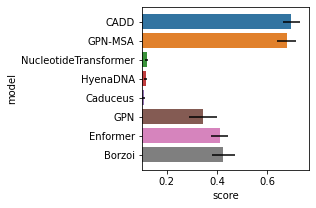

In [32]:
plt.figure(figsize=(3,3))
#sns.pointplot(
sns.barplot(
    data=df,
    y="model",
    x="score",
    #join=False,
)

plt.errorbar(
    x=df["score"],
    y=df["model"],
    xerr=df["se"],
    fmt='none',      # Do not add markers (those are already in the pointplot)
    color="black",
)

plt.xlim(0.1)

In [42]:
dfs = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if model == "Ensemble" and modality == "Zero-shot":
                    continue
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path)
                df["dataset"] = dataset_renaming.get(dataset, dataset)
                df["subset"] = subset_renaming.get(subset, subset)
                df["modality"] = modality
                df["model"] = model
                dfs.append(df)
df = pd.concat(dfs)
df

,chrom,n,Model,AUPRC,dataset,subset,modality,model
0,1,210,CADD.plus.RawScore,0.445951,Mendelian traits,Non-coding,Zero-shot,CADD
1,2,260,CADD.plus.RawScore,0.740507,Mendelian traits,Non-coding,Zero-shot,CADD
2,3,320,CADD.plus.RawScore,0.819572,Mendelian traits,Non-coding,Zero-shot,CADD
3,5,50,CADD.plus.RawScore,0.422789,Mendelian traits,Non-coding,Zero-shot,CADD
4,6,40,CADD.plus.RawScore,0.271075,Mendelian traits,Non-coding,Zero-shot,CADD
...,...,...,...,...,...,...,...,...
17,18,290,Enformer+GPN-MSA+CADD.LogisticRegression.chrom,0.411377,Complex traits,Non-coding,Linear probing,Ensemble
18,19,610,Enformer+GPN-MSA+CADD.LogisticRegression.chrom,0.342684,Complex traits,Non-coding,Linear probing,Ensemble
19,20,530,Enformer+GPN-MSA+CADD.LogisticRegression.chrom,0.270244,Complex traits,Non-coding,Linear probing,Ensemble
20,21,140,Enformer+GPN-MSA+CADD.LogisticRegression.chrom,0.431087,Complex traits,Non-coding,Linear probing,Ensemble


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/categorical.py:3203: User

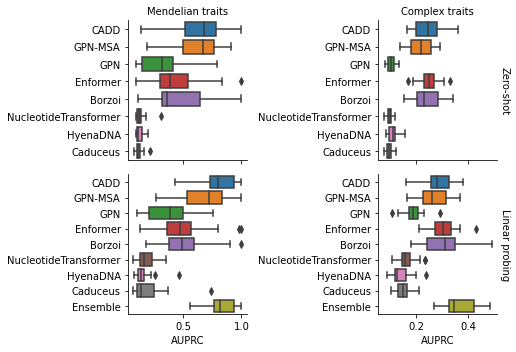

In [34]:
g = sns.catplot(
    data=df,
    y="model",
    x="AUPRC",
    col="dataset",
    row="modality",
    kind="box",
    margin_titles=True,
    sharex="col",
    sharey=False,#"row",
    height=2.5,
    aspect=1.5,
);
g.set(
    ylabel="",
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

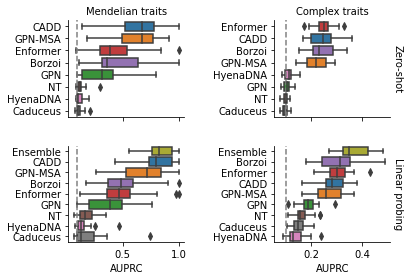

In [48]:
g = sns.FacetGrid(
    df,
    col="dataset",
    row="modality",
    margin_titles=True,
    sharex="col",
    sharey=False,#"row",
    height=2.0,
    aspect=1.5,
)

def my_boxplot(data, **kwargs):
    ax = plt.gca()
    sns.boxplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        order=data.groupby("model")["AUPRC"].median().sort_values(ascending=False).index,
        palette=palette,
    )
    ax.axvline(x=0.1, color="grey", linestyle="--")

g.map_dataframe(my_boxplot)

g.set(
    ylabel="",
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");

In [5]:
def format_score(x):
    return (x * 100).round().astype(int).apply(lambda y: f"{y:02d}")

def format_se(x):
    assert (x * 100).max() < 10
    return (x * 100).round().astype(int).apply(lambda y: f"{y:01d}")

df["value"] = format_score(df.score) + "$\pm$" + format_se(df.se)
#df["value"] = df.score.apply(lambda x: f"{x:.2f}") + "$\pm$" + df.se.apply(lambda x: f"{x:.2f}")

In [6]:
#df.loc[(df.model.isin(["Enformer", "Borzoi", "GPN"])) & (df.subset!="non_missense"), "value"] = "-"

In [14]:
bold_values = [
    ("mendelian_matched_9", "all", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "all", "Zero-shot", "GPN-MSA"),
    ("mendelian_matched_9", "missense_variant", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "missense_variant", "Zero-shot", "GPN-MSA"),
    ("mendelian_matched_9", "non_missense", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "non_missense", "Zero-shot", "GPN-MSA"),

    ("mendelian_matched_9", "all", "Linear probing", "CADD"),
    ("mendelian_matched_9", "all", "Linear probing", "Ensemble"),
    ("mendelian_matched_9", "missense_variant", "Linear probing", "CADD"),
    ("mendelian_matched_9", "missense_variant", "Linear probing", "Ensemble"),
    ("mendelian_matched_9", "non_missense", "Linear probing", "CADD"),
    ("mendelian_matched_9", "non_missense", "Linear probing", "Ensemble"),

    ("gwas_matched_9", "all", "Zero-shot", "CADD"),
    ("gwas_matched_9", "all", "Zero-shot", "GPN-MSA"),
    ("gwas_matched_9", "missense_variant", "Zero-shot", "CADD"),
    #("gwas_matched_9", "missense_variant", "Zero-shot", "GPN-MSA"),
    ("gwas_matched_9", "non_missense", "Zero-shot", "Enformer"),
    ("gwas_matched_9", "non_missense", "Zero-shot", "Borzoi"),

    ("gwas_matched_9", "all", "Linear probing", "Ensemble"),
    ("gwas_matched_9", "missense_variant", "Linear probing", "Ensemble"),
    ("gwas_matched_9", "non_missense", "Linear probing", "Ensemble"),
]

for dataset, subset, modality, model in bold_values:
    mask = (
        (df.dataset==dataset) & (df.subset==subset) &
        (df.modality==modality) & (df.model==model)
    )
    df.loc[mask, "value"] = r"\textbf{" + df.loc[mask, "value"] + "}"

In [7]:
df.dataset = df.dataset.map({
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
})
df.subset = df.subset.map({
    "all": "All",
    "missense_variant": "Coding",
    "non_coding": "Non-coding",
})

df.dataset = df.dataset.map({
    "Mendelian traits": r"\textbf{Mendelian traits}",
    "Complex traits": r"\textbf{Complex traits}",
})
df.modality = df.modality.map({
    "Zero-shot": r"\textbf{Zero-shot}",
    "Linear probing": r"\textbf{Linear probing}",
})

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

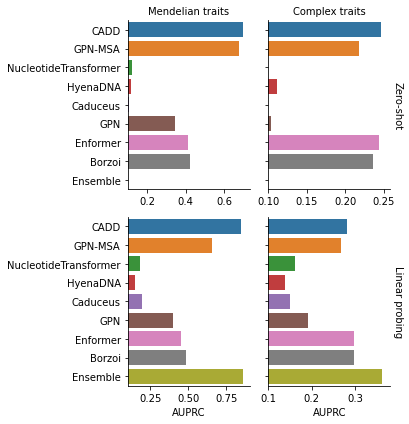

In [9]:
# TODO: get the old plotting code
# TODO: add error bars

g = sns.catplot(
    data=df.rename(columns={"score": "AUPRC"}),
    y="model",
    x="AUPRC",
    row="modality",
    col="dataset",
    kind="bar",
    #kind="point", join=False,
    sharex=False,
    margin_titles=True,
    height=3,
)
g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");

In [8]:
df = df.pivot_table(
    index=["modality", "model"],
    columns=[
        "dataset",
        #"subset",
    ],
    values="value", aggfunc="first", sort=False,
)
df

dataset                                       \textbf{Mendelian traits}  \
modality                model                                             
\textbf{Zero-shot}      CADD                                   70$\pm$3   
                        GPN-MSA                                68$\pm$4   
                        NucleotideTransformer                  12$\pm$1   
                        HyenaDNA                               12$\pm$1   
                        Caduceus                               11$\pm$1   
                        GPN                                    34$\pm$5   
                        Enformer                               41$\pm$3   
                        Borzoi                                 42$\pm$5   
\textbf{Linear probing} CADD                                   84$\pm$3   
                        GPN-MSA                                66$\pm$5   
                        NucleotideTransformer                  18$\pm$2   
                        HyenaDNA                               15$\pm$1   
                        Caduceus                               19$\pm$5   
                        GPN                                    40$\pm$6   
                        Enformer                               45$\pm$4   
                        Borzoi                                 49$\pm$4   
                        Ensemble                               86$\pm$2   

dataset                                       \textbf{Complex traits}  
modality                model                                          
\textbf{Zero-shot}      CADD                                 25$\pm$1  
                        GPN-MSA                              22$\pm$1  
                        NucleotideTransformer                10$\pm$0  
                        HyenaDNA                             11$\pm$0  
                        Caduceus                             10$\pm$0  
                        GPN                                  10$\pm$0  
                        Enformer                             24$\pm$1  
                        Borzoi                               24$\pm$1  
\textbf{Linear probing} CADD                                 28$\pm$1  
                        GPN-MSA                              27$\pm$1  
                        NucleotideTransformer                16$\pm$1  
                        HyenaDNA                             14$\pm$1  
                        Caduceus                             15$\pm$1  
                        GPN                                  19$\pm$1  
                        Enformer                             30$\pm$1  
                        Borzoi                               30$\pm$1  
                        Ensemble                             36$\pm$1

In [9]:
df.index.names = [None, None]
#df.columns.names = [None, None]
df.columns.name = None

In [10]:
print(df.to_latex(multicolumn_format='c', escape=False))

\begin{tabular}{llll}
\toprule
 &  & \textbf{Mendelian traits} & \textbf{Complex traits} \\
\midrule
\multirow[t]{8}{*}{\textbf{Zero-shot}} & CADD & 70$\pm$3 & 25$\pm$1 \\
 & GPN-MSA & 68$\pm$4 & 22$\pm$1 \\
 & NucleotideTransformer & 12$\pm$1 & 10$\pm$0 \\
 & HyenaDNA & 12$\pm$1 & 11$\pm$0 \\
 & Caduceus & 11$\pm$1 & 10$\pm$0 \\
 & GPN & 34$\pm$5 & 10$\pm$0 \\
 & Enformer & 41$\pm$3 & 24$\pm$1 \\
 & Borzoi & 42$\pm$5 & 24$\pm$1 \\
\cline{1-4}
\multirow[t]{9}{*}{\textbf{Linear probing}} & CADD & 84$\pm$3 & 28$\pm$1 \\
 & GPN-MSA & 66$\pm$5 & 27$\pm$1 \\
 & NucleotideTransformer & 18$\pm$2 & 16$\pm$1 \\
 & HyenaDNA & 15$\pm$1 & 14$\pm$1 \\
 & Caduceus & 19$\pm$5 & 15$\pm$1 \\
 & GPN & 40$\pm$6 & 19$\pm$1 \\
 & Enformer & 45$\pm$4 & 30$\pm$1 \\
 & Borzoi & 49$\pm$4 & 30$\pm$1 \\
 & Ensemble & 86$\pm$2 & 36$\pm$1 \\
\cline{1-4}
\bottomrule
\end{tabular}

